<a href="https://colab.research.google.com/github/Mikhail-Klochkov/ml_intro/blob/master/oversampling_undersampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip '/content/drive/MyDrive/Colab_Notebooks/archive.zip' -d data


Archive:  /content/drive/MyDrive/Colab_Notebooks/archive.zip
replace data/creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from tqdm import tqdm

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('data/creditcard.csv')

### Undersampling


In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
def time_represent(seconds, days = False):
  # get seconds and transform to (h, m, s)
  minutes_ = int(seconds//60)
  seconds_ = int(seconds % 60)
  hours_ = int(minutes_ // 60)
  minutes_ = int(minutes_ % 60) 

  if (days):
    days_ = int(hours_//24)
    hours_ = int(hours_ % 24)
    return days_, hours_, minutes_, seconds_
  else:
    return hours_, minutes_, seconds_

def get_days(seconds):
  return int(seconds // (60 * 60 * 24))


class Time():

  def __init__(self, seconds, days = False):
    time_list = time_represent(seconds, days = days)
    self._d, self._h, self._m, self._s = time_list
  
  def get_d(self):
    return self._d

  def get_h(self):
    return self._h

  def get_m(self):
    return self._m

  def get_s(self):
    return self._s

def get_d(s):
  t = Time(s, days = True)
  return t.get_d()


def get_h(s):
  t = Time(s, days = True)
  return t.get_h()

  
def get_m(s):
  t = Time(s, days = True)
  return t.get_m()


def get_s(s):
  t = Time(s, days = True)
  return t.get_s()

### Отдельную выборку с небольшим предпроцессингом


In [ ]:
df_copy = df.copy(deep = True)
X_c = df_copy.drop(columns = ['Class'])
y_c = df_copy['Class']


In [ ]:
new_features = ['t_' + t for t in ['d', 'h', 'm', 's']]
new_features

['t_d', 't_h', 't_m', 't_s']

In [ ]:
idx = 0
X_c[new_features[idx]] = X_c.Time.apply(lambda s: get_d(s))

idx = 1
X_c[new_features[idx]] = X_c.Time.apply(lambda s: get_h(s))

idx = 2
X_c[new_features[idx]] = X_c.Time.apply(lambda s: get_m(s))

idx = 3
X_c[new_features[idx]] = X_c.Time.apply(lambda s: get_s(s))

In [ ]:
X_c.tail(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,t_d,t_h,t_m,t_s
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,1,23,59,46
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,1,23,59,47
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,1,23,59,48
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,1,23,59,48
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,1,23,59,52


Мы пока оставили колонку Timе, она хорошо влияла на ответ.

In [ ]:
X_c = X_c.drop(columns = ['t_s', 't_m', 't_d'])
X_c['night'] = X_c['t_h'].apply(lambda h: int(h <= 10))
X_c['zero_amount'] = X_c['Amount'].apply(lambda a: int(a == 0)) 

numeric_cols = [col for col in X_c.columns if col[0] == 'V']
numeric_cols = numeric_cols + ['Amount'] + ['Time']

X_c = X_c.drop(columns = ['t_h']) # Убрали часы, слишком избыточна 
X_c.head(5), numeric_cols

(   Time        V1        V2        V3  ...       V28  Amount  night  zero_amount
 0   0.0 -1.359807 -0.072781  2.536347  ... -0.021053  149.62      1            0
 1   0.0  1.191857  0.266151  0.166480  ...  0.014724    2.69      1            0
 2   1.0 -1.358354 -1.340163  1.773209  ... -0.059752  378.66      1            0
 3   1.0 -0.966272 -0.185226  1.792993  ...  0.061458  123.50      1            0
 4   2.0 -1.158233  0.877737  1.548718  ...  0.215153   69.99      1            0
 
 [5 rows x 32 columns],
 ['V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6',
  'V7',
  'V8',
  'V9',
  'V10',
  'V11',
  'V12',
  'V13',
  'V14',
  'V15',
  'V16',
  'V17',
  'V18',
  'V19',
  'V20',
  'V21',
  'V22',
  'V23',
  'V24',
  'V25',
  'V26',
  'V27',
  'V28',
  'Amount',
  'Time'])

In [ ]:
X_c.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,night,zero_amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,1,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,1,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,1,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,1,0


In [ ]:
X_train_all_c, X_test_all_c, y_train_all_c, y_test_all_c = train_test_split(X_c, y_c, 
                                                              test_size = 0.2, random_state = 42)

print('percentage 1 label in train: {:.3f}\npercentage 1 label in test: {:.3f}'.format((y_train_all_c == 1).sum()*100/y_train_all_c.shape[0],
                                           (y_test_all_c == 1).sum()*100/y_test_all_c.shape[0]))

percentage 1 label in train: 0.173
percentage 1 label in test: 0.172


In [ ]:
X = df.drop(columns = ['Class'])
y = df['Class']

In [ ]:
print('Fraud percentage: {:.2f} %, non-Fraud persentage: {:.2f} %'.format((y == 1).sum()*100./y.shape[0], 
                                                              (y == 0).sum()*100./y.shape[0]))

Fraud percentage: 0.17 %, non-Fraud persentage: 99.83 %


In [ ]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('persantage fraud in train: {:.2f} %,\npersentage non-fraud in test: {:.2f} %'.format((y_train_all == 0).sum()*100./y.shape[0],
                                                  (y_test_all == 0).sum()*100./y.shape[0]))

persantage fraud in train: 79.86 %,
persentage non-fraud in test: 19.97 %


In [ ]:
# undersampling technique
def return_undersampling_data(X, y, nums = None):
  """
  for binary classification [0, 1]
  """
  assert(X.shape[0] == y.shape[0])
  unique, counts = np.unique(y.values, return_counts = True)
  assert(all(unique == [0,1])) 
  label_big = unique[counts.argmax()]
  label_small = unique[counts.argmin()]
  #print('label {} is disbalance'.format(label_big))
  indeces_small = y[y == label_small].index
  indeces = np.random.choice(X.index, size = len(indeces_small) if nums is None else nums)
  X_copy = X.copy(deep = True)
  y_copy = y.copy(deep = True)
  indeces = np.concatenate([indeces_small.tolist(), indeces.tolist()])
  X_under, y_under = X_copy.loc[indeces, :], y_copy[indeces]
  
  return X_under, y_under
num_of_fraud = len(y_train_all[y_train_all == 1].index)
indeces = np.random.choice(X_train_all.index, size = num_of_fraud)

In [ ]:
def cross_val_score_my(model, X, y, cv = 5, scoring = 'roc_auc', text = '', return_scores = False):
  assert(X.shape[0] == y.shape[0])
  cv = StratifiedKFold(n_splits = cv, shuffle = True)
  n_scores = cross_val_score(model, X, y, cv = cv, scoring = scoring)

  print('cross_val_score {} : {:.3f} +- {:.3f} '.format(text, n_scores.mean(),
                                                    n_scores.std()))
  
  if(return_scores):
    return n_scores

In [ ]:
X_under_train, y_under_train = return_undersampling_data(X_train_all, y_train_all)


In [ ]:
# Должно быть 50\50
assert((y_under_train == 0).sum()/(y_under_train == 1).sum() == 1.)

In [ ]:
from sklearn.metrics import SCORERS, f1_score, accuracy_score, roc_auc_score, recall_score, precision_score, precision_recall_fscore_support
keys = set(SCORERS.keys())
scorings = ['f1', 'recall', 'precision', 'roc_auc', 'accuracy']
for scor in scorings:
  if(scor not in keys):
    print(scor, ' not exsist!')

metrics_all = [f1_score, recall_score, precision_score, roc_auc_score, accuracy_score]


In [ ]:
from sklearn.pipeline import make_pipeline, Pipeline

scaler_rob = RobustScaler()
scaler_std = StandardScaler()
times = 7
best_params = []
cross_val_scores = []
metric_on_test_data_times = []

for idx in tqdm(range(times)):
  metrics_on_test_data = {}
  print('time: {}\n {}'.format((idx+1), '-'*30))
  pipe = make_pipeline(
      scaler_std,
      LogisticRegression() # balanced not doing
  )
  X_under_train, y_under_train = return_undersampling_data(X_train_all, y_train_all)

  C = np.arange(0.05, 7, 8)
  hyperparam_grid = {
                   "logisticregression__penalty": ["l1", "l2"],
                   "logisticregression__C": C, 
                   }
  cv = StratifiedKFold(n_splits = 4, shuffle = True)
  grid = GridSearchCV(pipe, hyperparam_grid, cv = cv, scoring = 'roc_auc') # maybe should be precision_recall_score
  grid.fit(X_under_train, y_under_train)
  best_model = grid.best_estimator_
  best_params.append(grid.best_estimator_.get_params()['logisticregression'])

  #----------------- cross_val_score on all undersample for all metrics -----------------#
  cross_val = {}
  print('cross_val on X_under, y_under\n')
  for scor in scorings:
    n_scores = cross_val_score_my(best_model, X_under_train, y_under_train, 
                                  cv = 5, scoring = scor, text = scor, return_scores = True)
    print('------------------------------------------------------------\n')
    cross_val[scor] = n_scores.mean()
  cross_val_scores.append(cross_val)
  #--------------------------------see on real test data ---------------------------------#

  print('Test\n')
  for idx, (scor_f, scor_name) in enumerate(zip(metrics_all, scorings), start = 1):
    y_pred = best_model.predict(X_test_all)
    y_pred_proba = best_model.predict_proba(X_test_all)
    if(scor_name.find('roc_auc') == 0):
      print('We calculate ROC_AUC score!')
      score = scor_f(y_test_all, y_pred_proba[:, 1])
    else:
      score = scor_f(y_test_all, y_pred)
    print('score {} on test data: {:.3f}'.format(scor_name, score))
    metrics_on_test_data[scor_name] = score

  metric_on_test_data_times.append(metrics_on_test_data)


    


  0%|          | 0/7 [00:00<?, ?it/s]

time: 1
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.918 +- 0.016 
------------------------------------------------------------

cross_val_score recall : 0.856 +- 0.044 
------------------------------------------------------------

cross_val_score precision : 0.986 +- 0.015 
------------------------------------------------------------

cross_val_score roc_auc : 0.974 +- 0.014 
------------------------------------------------------------

cross_val_score accuracy : 0.923 +- 0.012 
------------------------------------------------------------

Test

score f1 on test data: 0.266
score recall on test data: 0.878
score precision on test data: 0.157
We calculate ROC_AUC score!
score roc_auc on test data: 0.986


 14%|█▍        | 1/7 [00:00<00:05,  1.19it/s]

score accuracy on test data: 0.992
time: 2
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.918 +- 0.031 
------------------------------------------------------------

cross_val_score recall : 0.868 +- 0.035 
------------------------------------------------------------

cross_val_score precision : 0.994 +- 0.011 
------------------------------------------------------------

cross_val_score roc_auc : 0.976 +- 0.009 
------------------------------------------------------------

cross_val_score accuracy : 0.926 +- 0.018 
------------------------------------------------------------

Test

score f1 on test data: 0.230
score recall on test data: 0.888
score precision on test data: 0.132
We calculate ROC_AUC score!


 29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]

score roc_auc on test data: 0.988
score accuracy on test data: 0.990
time: 3
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.927 +- 0.017 
------------------------------------------------------------

cross_val_score recall : 0.871 +- 0.026 
------------------------------------------------------------

cross_val_score precision : 0.991 +- 0.007 
------------------------------------------------------------

cross_val_score roc_auc : 0.979 +- 0.008 
------------------------------------------------------------

cross_val_score accuracy : 0.928 +- 0.018 
------------------------------------------------------------

Test

score f1 on test data: 0.226
score recall on test data: 0.888
score precision on test data: 0.129
We calculate ROC_AUC score!
score roc_auc on test data: 0.986


 43%|████▎     | 3/7 [00:02<00:03,  1.20it/s]

score accuracy on test data: 0.990
time: 4
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.921 +- 0.012 
------------------------------------------------------------

cross_val_score recall : 0.861 +- 0.028 
------------------------------------------------------------

cross_val_score precision : 0.991 +- 0.007 
------------------------------------------------------------

cross_val_score roc_auc : 0.973 +- 0.012 
------------------------------------------------------------

cross_val_score accuracy : 0.925 +- 0.011 
------------------------------------------------------------

Test

score f1 on test data: 0.273
score recall on test data: 0.888
score precision on test data: 0.161
We calculate ROC_AUC score!
score roc_auc on test data: 0.984


 57%|█████▋    | 4/7 [00:03<00:02,  1.18it/s]

score accuracy on test data: 0.992
time: 5
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.917 +- 0.027 
------------------------------------------------------------

cross_val_score recall : 0.856 +- 0.043 
------------------------------------------------------------

cross_val_score precision : 0.980 +- 0.014 
------------------------------------------------------------

cross_val_score roc_auc : 0.976 +- 0.013 
------------------------------------------------------------

cross_val_score accuracy : 0.923 +- 0.025 
------------------------------------------------------------

Test

score f1 on test data: 0.249
score recall on test data: 0.867
score precision on test data: 0.146
We calculate ROC_AUC score!
score roc_auc on test data: 0.984


 71%|███████▏  | 5/7 [00:04<00:01,  1.19it/s]

score accuracy on test data: 0.991
time: 6
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.925 +- 0.013 
------------------------------------------------------------

cross_val_score recall : 0.865 +- 0.028 
------------------------------------------------------------

cross_val_score precision : 0.997 +- 0.006 
------------------------------------------------------------

cross_val_score roc_auc : 0.977 +- 0.011 
------------------------------------------------------------

cross_val_score accuracy : 0.930 +- 0.015 
------------------------------------------------------------

Test

score f1 on test data: 0.260
score recall on test data: 0.888
score precision on test data: 0.152
We calculate ROC_AUC score!
score roc_auc on test data: 0.986


 86%|████████▌ | 6/7 [00:05<00:00,  1.17it/s]

score accuracy on test data: 0.991
time: 7
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.916 +- 0.015 
------------------------------------------------------------

cross_val_score recall : 0.855 +- 0.054 
------------------------------------------------------------

cross_val_score precision : 0.988 +- 0.011 
------------------------------------------------------------

cross_val_score roc_auc : 0.973 +- 0.005 
------------------------------------------------------------

cross_val_score accuracy : 0.919 +- 0.017 
------------------------------------------------------------

Test

score f1 on test data: 0.281


100%|██████████| 7/7 [00:05<00:00,  1.18it/s]

score recall on test data: 0.857
score precision on test data: 0.168
We calculate ROC_AUC score!
score roc_auc on test data: 0.985
score accuracy on test data: 0.992


In [ ]:

def Downsampling_block(X_train_all, y_train_all, X_test_all, y_test_all,
                       scaler = 'std', times = 7, cv_nums = 4, scoring = 'roc_auc'):

  if(scaler == 'std'):
    scaler_std = StandardScaler()
  else:
    scaler_rob = RobustScaler()
  times = times
  best_params = []
  cross_val_scores = []
  metric_on_test_data_times = []

  for idx in tqdm(range(times)):
    metrics_on_test_data = {}
    print('time: {}\n {}'.format((idx+1), '-'*30))
    pipe = make_pipeline(
        scaler_std,
        LogisticRegression() # balanced not doing
    )
    X_under_train, y_under_train = return_undersampling_data(X_train_all, y_train_all)

    C = np.arange(0.05, 7, 8)
    hyperparam_grid = {
                    "logisticregression__penalty": ["l1", "l2"],
                    "logisticregression__C": C, 
                    }
    
    cv = StratifiedKFold(n_splits = cv_nums, shuffle = True)
    grid = GridSearchCV(pipe, hyperparam_grid, cv = cv, scoring = scoring) # maybe should be precision_recall_score
    grid.fit(X_under_train, y_under_train)
    best_model = grid.best_estimator_
    best_params.append(grid.best_estimator_.get_params()['logisticregression'])

    #----------------- cross_val_score on all undersample for all metrics -----------------#
    cross_val = {}
    print('cross_val on X_under, y_under\n')
    for scor in scorings:
      n_scores = cross_val_score_my(best_model, X_under_train, y_under_train, 
                                    cv = 5, scoring = scor, text = scor, return_scores = True)
      print('------------------------------------------------------------\n')
      cross_val[scor] = n_scores.mean()
    cross_val_scores.append(cross_val)
    #--------------------------------see on real test data ---------------------------------#

    print('Test\n')
    for idx, (scor_f, scor_name) in enumerate(zip(metrics_all, scorings), start = 1):
      y_pred = best_model.predict(X_test_all)
      y_pred_proba = best_model.predict_proba(X_test_all)
      if(scor_name.find('roc_auc') == 0):
        print('We calculate ROC_AUC score!')
        score = scor_f(y_test_all, y_pred_proba[:, 1])
      else:
        score = scor_f(y_test_all, y_pred)
      print('score {} on test data: {:.3f}'.format(scor_name, score))
      metrics_on_test_data[scor_name] = score

    metric_on_test_data_times.append(metrics_on_test_data)

  out = {'best_params' : best_params, 
         'cross_val_scores' : cross_val_scores,
         'metric_on_test_data_times': metric_on_test_data_times,
         'best_model': best_model}

  return out 

      
out_oversampling = Downsampling_block(X_train_all, y_train_all, X_test_all, y_test_all)

  0%|          | 0/7 [00:00<?, ?it/s]

time: 1
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.923 +- 0.009 
------------------------------------------------------------

cross_val_score recall : 0.869 +- 0.051 
------------------------------------------------------------

cross_val_score precision : 0.994 +- 0.011 
------------------------------------------------------------

cross_val_score roc_auc : 0.973 +- 0.009 
------------------------------------------------------------

cross_val_score accuracy : 0.931 +- 0.020 
------------------------------------------------------------

Test

score f1 on test data: 0.283


 14%|█▍        | 1/7 [00:00<00:05,  1.20it/s]

score recall on test data: 0.867
score precision on test data: 0.169
We calculate ROC_AUC score!
score roc_auc on test data: 0.980
score accuracy on test data: 0.992
time: 2
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.919 +- 0.028 
------------------------------------------------------------

cross_val_score recall : 0.858 +- 0.059 
------------------------------------------------------------

cross_val_score precision : 0.988 +- 0.006 
------------------------------------------------------------

cross_val_score roc_auc : 0.977 +- 0.006 
------------------------------------------------------------

cross_val_score accuracy : 0.923 +- 0.020 
------------------------------------------------------------

Test

score f1 on test data: 0.204
score recall on test data: 0.867
score precision on test data: 0.115
We calculate ROC_AUC score!
score roc_auc on test data: 0.984


 29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]

score accuracy on test data: 0.988
time: 3
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.918 +- 0.032 
------------------------------------------------------------

cross_val_score recall : 0.860 +- 0.035 
------------------------------------------------------------

cross_val_score precision : 0.991 +- 0.007 
------------------------------------------------------------

cross_val_score roc_auc : 0.974 +- 0.010 
------------------------------------------------------------

cross_val_score accuracy : 0.926 +- 0.015 
------------------------------------------------------------

Test

score f1 on test data: 0.274
score recall on test data: 0.888


 43%|████▎     | 3/7 [00:02<00:03,  1.20it/s]

score precision on test data: 0.162
We calculate ROC_AUC score!
score roc_auc on test data: 0.985
score accuracy on test data: 0.992
time: 4
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.917 +- 0.024 
------------------------------------------------------------

cross_val_score recall : 0.863 +- 0.035 
------------------------------------------------------------

cross_val_score precision : 0.986 +- 0.001 
------------------------------------------------------------

cross_val_score roc_auc : 0.977 +- 0.003 
------------------------------------------------------------

cross_val_score accuracy : 0.926 +- 0.021 
------------------------------------------------------------

Test

score f1 on test data: 0.295
score recall on test data: 0.878
score precision on test data: 0.177
We calculate ROC_AUC score!
score roc_auc on test data: 0.984


 57%|█████▋    | 4/7 [00:03<00:02,  1.20it/s]

score accuracy on test data: 0.993
time: 5
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.923 +- 0.018 
------------------------------------------------------------

cross_val_score recall : 0.860 +- 0.029 
------------------------------------------------------------

cross_val_score precision : 0.989 +- 0.010 
------------------------------------------------------------

cross_val_score roc_auc : 0.978 +- 0.016 
------------------------------------------------------------

cross_val_score accuracy : 0.925 +- 0.034 
------------------------------------------------------------

Test

score f1 on test data: 0.256
score recall on test data: 0.888


 71%|███████▏  | 5/7 [00:04<00:01,  1.20it/s]

score precision on test data: 0.149
We calculate ROC_AUC score!
score roc_auc on test data: 0.982
score accuracy on test data: 0.991
time: 6
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.923 +- 0.018 
------------------------------------------------------------

cross_val_score recall : 0.868 +- 0.022 
------------------------------------------------------------

cross_val_score precision : 0.992 +- 0.011 
------------------------------------------------------------

cross_val_score roc_auc : 0.979 +- 0.008 
------------------------------------------------------------

cross_val_score accuracy : 0.933 +- 0.023 
------------------------------------------------------------

Test

score f1 on test data: 0.182
score recall on test data: 0.888
score precision on test data: 0.101
We calculate ROC_AUC score!
score roc_auc on test data: 0.986


 86%|████████▌ | 6/7 [00:05<00:00,  1.19it/s]

score accuracy on test data: 0.986
time: 7
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.922 +- 0.021 
------------------------------------------------------------

cross_val_score recall : 0.865 +- 0.019 
------------------------------------------------------------

cross_val_score precision : 0.986 +- 0.013 
------------------------------------------------------------

cross_val_score roc_auc : 0.977 +- 0.005 
------------------------------------------------------------

cross_val_score accuracy : 0.924 +- 0.020 
------------------------------------------------------------

Test

score f1 on test data: 0.248
score recall on test data: 0.888


100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

score precision on test data: 0.144
We calculate ROC_AUC score!
score roc_auc on test data: 0.984
score accuracy on test data: 0.991


In [ ]:
def Oversampling_block(X_train_all, y_train_all, X_test_all, y_test_all, 
                       scaler = 'std', times = 7,
                       cv_nums = 4, scoring = 'roc_auc', 
                       num = 1000, k_neighbors = 10):
  
  cross_val_scores = [] 
  test_scores_times = []
  best_params = []

  if(scaler == 'std'):
    scaler = StandardScaler()
  else:
    scaler = RobustScaler()
  print('times ', times)
  for idx, time in enumerate(range(times)):
    test_scores = {}
    print('time: {}\n {}'.format((idx+1), '-'*30))
    #-------Changes for type of samplings -------#
    X_under, y_under = return_undersampling_data(X_train_all, y_train_all, nums = num+1)
    smote = SMOTE(k_neighbors = k_neighbors)
    X_balanced, y_balanced = smote.fit_sample(X_under, y_under)
    
    pipe = make_pipeline(
          scaler,
          LogisticRegression(class_weight = 'balanced') # balanced not doing
      )
    C = np.arange(0.05, 7, 8)
    hyperparam_grid = {
                      "logisticregression__penalty": ["l1", "l2"],
                      "logisticregression__C": C, 
                      "logisticregression__fit_intercept": [True, False],
                      }
      
    cv = StratifiedKFold(n_splits = cv_nums, shuffle = True)
    grid = GridSearchCV(pipe, hyperparam_grid, cv = cv, n_jobs = -1, scoring = scoring)
    grid.fit(X_balanced, y_balanced)
    best_model = grid.best_estimator_
    best_params.append(grid.best_estimator_.get_params()['logisticregression'])

    #----------------- cross_val_score on all undersample for all metrics -----------------#
    cross_val = {}
    print('cross_val on X_balanced, y_balanced\n')
    for scor in scorings:
      n_scores = cross_val_score_my(best_model, X_balanced, y_balanced, 
                                      cv = 5, scoring = scor, text = scor, return_scores = True)
      print('------------------------------------------------------------\n')
      cross_val[scor] = n_scores.mean()
      cross_val_scores.append(cross_val)
      #--------------------------------see on real test data ---------------------------------#

    print('Test\n')
    for idx, (scor_f, scor_name) in enumerate(zip(metrics_all, scorings), start = 1):
      y_pred = best_model.predict(X_test_all)
      y_pred_proba = best_model.predict_proba(X_test_all)
      if(scor_name.find('roc_auc') == 0):
        print('We calculate ROC_AUC score!')
        score = scor_f(y_test_all, y_pred_proba[:, 1])
      else:
        score = scor_f(y_test_all, y_pred)
      print('score {} on test data: {:.3f}'.format(scor_name, score))
      test_scores[scor_name] = score
    
    test_scores_times.append(test_scores)

    out = {'best_params' : best_params, 
         'cross_val_scores' : cross_val_scores,
         'metric_on_test_data_times': test_scores_times,
         'best_model': best_model}

  return out


In [ ]:
best_params

[LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 

In [ ]:
# Посмотрим средние метрики на всех times
print('cross_validation on X_under, y_under\n')
means_from_cross_val = {}
for scor_name in scorings:
  score_mean_current = []
  for time in range(times):
    score_mean_current.append(cross_val_scores[time][scor_name])
  score_curr = np.array(score_mean_current)
  means_from_cross_val[scor_name] = score_curr.mean()
  print('On {} times mean {} : {:.3f} +- {:.3f}'.format(times,scor_name, score_curr.mean(), 
                                              score_curr.std()))



cross_validation on X_under, y_under

On 7 times mean f1 : 0.920 +- 0.004
On 7 times mean recall : 0.862 +- 0.006
On 7 times mean precision : 0.990 +- 0.005
On 7 times mean roc_auc : 0.976 +- 0.002
On 7 times mean accuracy : 0.925 +- 0.003


In [ ]:
# посмотрим на предсказание на фиксированном тесте данных
print('test_data on X_test_all, y_test_all\n')
means_from_test_data = {}
for scor_name in scorings:
  score_mean_current = []
  for time in range(times):
    score_mean_current.append(metric_on_test_data_times[time][scor_name])
  score_curr = np.array(score_mean_current)
  means_from_test_data[scor_name] = score_curr.mean()
  print('On {} times mean {} : {:.3f} +- {:.3f}'.format(times,scor_name, score_curr.mean(), 
                                              score_curr.std()))

test_data on X_test_all, y_test_all

On 7 times mean f1 : 0.255 +- 0.020
On 7 times mean recall : 0.879 +- 0.011
On 7 times mean precision : 0.149 +- 0.014
On 7 times mean roc_auc : 0.986 +- 0.001
On 7 times mean accuracy : 0.991 +- 0.001


In [ ]:
# Теперь на другом подходе, когда необходимо создавать новые данные!(SMOTE)
from imblearn.over_sampling import SMOTE

# k_neighbours is a hyperparameter
smote = SMOTE(k_neighbors = 10)
X_new_train_all, y_new_train_all = smote.fit_sample(X_train_all, y_train_all)

In [ ]:
assert((y_new_train_all == 1).sum()/y_new_train_all.shape[0] == 0.5)
assert((y_new_train_all == 0).sum()/y_new_train_all.shape[0] == 0.5)

In [ ]:
# Вопрос, а можно ли как-то делать сразу две стратегии и убрать некоторые данные и добавить для баланса 
nums = [500, 1000, 2000, 4000, 10000]
num = nums[4]
times = 5
cross_val_scores = [] 
test_scores_times = []
best_params = []

scaler_std = StandardScaler()
rob_scaler = RobustScaler()

for time in range(times):
  test_scores = {}
  print('time: {}\n {}'.format((idx+1), '-'*30))
  #-------Changes for type of samplings -------#
  X_under, y_under = return_undersampling_data(X_train_all, y_train_all, nums = num)
  smote = SMOTE(k_neighbors = 10)
  X_balanced, y_balanced = smote.fit_sample(X_under, y_under)
  
  pipe = make_pipeline(
        scaler_std,
        LogisticRegression() # balanced not doing
    )
  C = np.arange(0.05, 7, 8)
  hyperparam_grid = {
                    "logisticregression__penalty": ["l1", "l2"],
                    "logisticregression__C": C, 
                     "logisticregression__fit_intercept": [True, False],
                    }
    
  cv = StratifiedKFold(n_splits = 5, shuffle = True)
  grid = GridSearchCV(pipe, hyperparam_grid, cv = cv, n_jobs = -1, scoring = 'roc_auc')
  grid.fit(X_balanced, y_balanced)
  best_model = grid.best_estimator_
  best_params.append(grid.best_estimator_.get_params()['logisticregression'])

  #----------------- cross_val_score on all undersample for all metrics -----------------#
  cross_val = {}
  print('cross_val on X_balanced, y_balanced\n')
  for scor in scorings:
    n_scores = cross_val_score_my(best_model, X_balanced, y_balanced, 
                                    cv = 5, scoring = scor, text = scor, return_scores = True)
    print('------------------------------------------------------------\n')
    cross_val[scor] = n_scores.mean()
    cross_val_scores.append(cross_val)
    #--------------------------------see on real test data ---------------------------------#

  print('Test\n')
  for idx, (scor_f, scor_name) in enumerate(zip(metrics_all, scorings), start = 1):
    y_pred = best_model.predict(X_test_all)
    y_pred_proba = best_model.predict_proba(X_test_all)
    if(scor_name.find('roc_auc') == 0):
      print('We calculate ROC_AUC score!')
      score = scor_f(y_test_all, y_pred_proba[:, 1])
    else:
      score = scor_f(y_test_all, y_pred)
    print('score {} on test data: {:.3f}'.format(scor_name, score))
    test_scores[scor_name] = score
  
  test_scores_times.append(test_scores)



time: 6
 ------------------------------
cross_val on X_balanced, y_balanced

cross_val_score f1 : 0.969 +- 0.001 
------------------------------------------------------------

cross_val_score recall : 0.949 +- 0.005 
------------------------------------------------------------

cross_val_score precision : 0.990 +- 0.001 
------------------------------------------------------------

cross_val_score roc_auc : 0.995 +- 0.000 
------------------------------------------------------------

cross_val_score accuracy : 0.970 +- 0.002 
------------------------------------------------------------

Test

score f1 on test data: 0.252
score recall on test data: 0.898
score precision on test data: 0.146
We calculate ROC_AUC score!
score roc_auc on test data: 0.985
score accuracy on test data: 0.991
time: 6
 ------------------------------
cross_val on X_balanced, y_balanced

cross_val_score f1 : 0.968 +- 0.001 
------------------------------------------------------------

cross_val_score recall : 0.94

In [ ]:
# Посмотрим средние метрики на всех times
print('cross_validation on X_under, y_under + SMOTE \n')
means_from_cross_val = {}
for scor_name in scorings:
  score_mean_current = []
  for time in range(times):
    score_mean_current.append(cross_val_scores[time][scor_name])
  score_curr = np.array(score_mean_current)
  means_from_cross_val[scor_name] = score_curr.mean()
  print('On {} times mean {} : {:.3f} +- {:.3f}'.format(times,scor_name, score_curr.mean(), 
                                              score_curr.std()))



cross_validation on X_under, y_under + SMOTE 

On 5 times mean f1 : 0.969 +- 0.000
On 5 times mean recall : 0.949 +- 0.000
On 5 times mean precision : 0.990 +- 0.000
On 5 times mean roc_auc : 0.995 +- 0.000
On 5 times mean accuracy : 0.970 +- 0.000


In [ ]:
# посмотрим на предсказание на фиксированном тесте данных
print('test_data on X_test_all, y_test_all\n for size on each class {}\n'.format(num))
means_from_test_data = {}
for scor_name in scorings:
  score_mean_current = []
  for time in range(times):
    score_mean_current.append(test_scores_times[time][scor_name])
  score_curr = np.array(score_mean_current)
  means_from_test_data[scor_name] = score_curr.mean()
  print('On {} times mean {} : {:.3f} +- {:.3f}'.format(times,scor_name, score_curr.mean(), 
                                              score_curr.std()))

test_data on X_test_all, y_test_all
 for size on each class 10000

On 5 times mean f1 : 0.244 +- 0.006
On 5 times mean recall : 0.896 +- 0.004
On 5 times mean precision : 0.142 +- 0.004
On 5 times mean roc_auc : 0.985 +- 0.001
On 5 times mean accuracy : 0.990 +- 0.000


### Тоже самое, только для X_c, y_c - немгого преобразованные данные

In [ ]:
out = Downsampling_block(X_train_all_c, y_train_all_c, X_test_all_c, y_test_all)

  0%|          | 0/7 [00:00<?, ?it/s]

time: 1
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.920 +- 0.020 
------------------------------------------------------------

cross_val_score recall : 0.861 +- 0.018 
------------------------------------------------------------

cross_val_score precision : 0.986 +- 0.013 
------------------------------------------------------------

cross_val_score roc_auc : 0.979 +- 0.014 
------------------------------------------------------------

cross_val_score accuracy : 0.925 +- 0.022 
------------------------------------------------------------

Test

score f1 on test data: 0.251
score recall on test data: 0.888
score precision on test data: 0.146
We calculate ROC_AUC score!


 14%|█▍        | 1/7 [00:00<00:05,  1.04it/s]

score roc_auc on test data: 0.986
score accuracy on test data: 0.991
time: 2
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.923 +- 0.031 
------------------------------------------------------------

cross_val_score recall : 0.866 +- 0.044 
------------------------------------------------------------

cross_val_score precision : 0.994 +- 0.007 
------------------------------------------------------------

cross_val_score roc_auc : 0.976 +- 0.011 
------------------------------------------------------------

cross_val_score accuracy : 0.933 +- 0.017 
------------------------------------------------------------

Test

score f1 on test data: 0.235
score recall on test data: 0.888
score precision on test data: 0.135
We calculate ROC_AUC score!
score roc_auc on test data: 0.986


 29%|██▊       | 2/7 [00:01<00:04,  1.07it/s]

score accuracy on test data: 0.990
time: 3
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.919 +- 0.028 
------------------------------------------------------------

cross_val_score recall : 0.855 +- 0.024 
------------------------------------------------------------

cross_val_score precision : 0.986 +- 0.009 
------------------------------------------------------------

cross_val_score roc_auc : 0.975 +- 0.016 
------------------------------------------------------------

cross_val_score accuracy : 0.924 +- 0.021 
------------------------------------------------------------

Test

score f1 on test data: 0.322


 43%|████▎     | 3/7 [00:02<00:03,  1.09it/s]

score recall on test data: 0.888
score precision on test data: 0.196
We calculate ROC_AUC score!
score roc_auc on test data: 0.983
score accuracy on test data: 0.994
time: 4
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.919 +- 0.039 
------------------------------------------------------------

cross_val_score recall : 0.861 +- 0.032 
------------------------------------------------------------

cross_val_score precision : 0.994 +- 0.007 
------------------------------------------------------------

cross_val_score roc_auc : 0.975 +- 0.006 
------------------------------------------------------------

cross_val_score accuracy : 0.929 +- 0.019 
------------------------------------------------------------

Test

score f1 on test data: 0.233
score recall on test data: 0.888
score precision on test data: 0.134
We calculate ROC_AUC score!
score roc_auc on test data: 0.984


 57%|█████▋    | 4/7 [00:03<00:02,  1.11it/s]

score accuracy on test data: 0.990
time: 5
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.922 +- 0.047 
------------------------------------------------------------

cross_val_score recall : 0.866 +- 0.037 
------------------------------------------------------------

cross_val_score precision : 0.994 +- 0.011 
------------------------------------------------------------

cross_val_score roc_auc : 0.981 +- 0.010 
------------------------------------------------------------

cross_val_score accuracy : 0.926 +- 0.025 
------------------------------------------------------------

Test

score f1 on test data: 0.184


 71%|███████▏  | 5/7 [00:04<00:01,  1.13it/s]

score recall on test data: 0.888
score precision on test data: 0.102
We calculate ROC_AUC score!
score roc_auc on test data: 0.985
score accuracy on test data: 0.986
time: 6
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.922 +- 0.020 
------------------------------------------------------------

cross_val_score recall : 0.860 +- 0.014 
------------------------------------------------------------

cross_val_score precision : 0.994 +- 0.007 
------------------------------------------------------------

cross_val_score roc_auc : 0.976 +- 0.007 
------------------------------------------------------------

cross_val_score accuracy : 0.930 +- 0.017 
------------------------------------------------------------

Test

score f1 on test data: 0.241
score recall on test data: 0.888
score precision on test data: 0.139
We calculate ROC_AUC score!
score roc_auc on test data: 0.979


 86%|████████▌ | 6/7 [00:05<00:00,  1.13it/s]

score accuracy on test data: 0.990
time: 7
 ------------------------------
cross_val on X_under, y_under

cross_val_score f1 : 0.915 +- 0.022 
------------------------------------------------------------

cross_val_score recall : 0.861 +- 0.056 
------------------------------------------------------------

cross_val_score precision : 0.983 +- 0.014 
------------------------------------------------------------

cross_val_score roc_auc : 0.978 +- 0.011 
------------------------------------------------------------

cross_val_score accuracy : 0.923 +- 0.030 
------------------------------------------------------------

Test

score f1 on test data: 0.223


100%|██████████| 7/7 [00:06<00:00,  1.13it/s]

score recall on test data: 0.888
score precision on test data: 0.127
We calculate ROC_AUC score!
score roc_auc on test data: 0.986
score accuracy on test data: 0.989


In [ ]:
# Посмотрим средние метрики на всех times

cross_cal_scores = out['cross_val_scores']
print('cross_validation on X_under, y_under\n')
means_from_cross_val = {}
for scor_name in scorings:
  score_mean_current = []
  for time in range(times):
    score_mean_current.append(cross_val_scores[time][scor_name])
  score_curr = np.array(score_mean_current)
  means_from_cross_val[scor_name] = score_curr.mean()
  print('On {} times mean {} : {:.3f} +- {:.3f}'.format(times,scor_name, score_curr.mean(), 
                                              score_curr.std()))

cross_validation on X_under, y_under

On 5 times mean f1 : 0.969 +- 0.000
On 5 times mean recall : 0.949 +- 0.000
On 5 times mean precision : 0.990 +- 0.000
On 5 times mean roc_auc : 0.995 +- 0.000
On 5 times mean accuracy : 0.970 +- 0.000


In [ ]:
# посмотрим на предсказание на фиксированном тесте данных
test_scores_times = out['metric_on_test_data_times']
#print('test_data on X_test_all, y_test_all\n for size on each class {}\n'.format(num))
means_from_test_data = {}
for scor_name in scorings:
  score_mean_current = []
  for time in range(times):
    score_mean_current.append(test_scores_times[time][scor_name])
  score_curr = np.array(score_mean_current)
  means_from_test_data[scor_name] = score_curr.mean()
  print('On {} times mean {} : {:.3f} +- {:.3f}'.format(times,scor_name, score_curr.mean(), 
                                              score_curr.std()))

On 5 times mean f1 : 0.245 +- 0.045
On 5 times mean recall : 0.888 +- 0.000
On 5 times mean precision : 0.143 +- 0.030
On 5 times mean roc_auc : 0.985 +- 0.001
On 5 times mean accuracy : 0.990 +- 0.002


In [ ]:
# Oversampling
out_balanced = Oversampling_block(X_train_all_c, y_train_all_c,
                                  X_test_all_c, y_test_all_c, num = 10000,
                                  scoring = 'recall')

times  7
time: 1
 ------------------------------
cross_val on X_balanced, y_balanced

cross_val_score f1 : 0.972 +- 0.004 
------------------------------------------------------------

cross_val_score recall : 0.954 +- 0.005 
------------------------------------------------------------

cross_val_score precision : 0.991 +- 0.002 
------------------------------------------------------------

cross_val_score roc_auc : 0.997 +- 0.001 
------------------------------------------------------------

cross_val_score accuracy : 0.972 +- 0.003 
------------------------------------------------------------

Test

score f1 on test data: 0.249
score recall on test data: 0.898
score precision on test data: 0.144
We calculate ROC_AUC score!
score roc_auc on test data: 0.987
score accuracy on test data: 0.991
time: 2
 ------------------------------
cross_val on X_balanced, y_balanced

cross_val_score f1 : 0.970 +- 0.002 
------------------------------------------------------------

cross_val_score reca

In [ ]:
# Посмотрим средние метрики на всех times

cross_cal_scores = out_balanced['cross_val_scores']
print('cross_validation on X_under, y_under\n')
means_from_cross_val = {}
for scor_name in scorings:
  score_mean_current = []
  for time in range(times):
    score_mean_current.append(cross_val_scores[time][scor_name])
  score_curr = np.array(score_mean_current)
  means_from_cross_val[scor_name] = score_curr.mean()
  print('On {} times mean {} : {:.3f} +- {:.3f}'.format(times,scor_name, score_curr.mean(), 
                                              score_curr.std()))

cross_validation on X_under, y_under

On 5 times mean f1 : 0.969 +- 0.000
On 5 times mean recall : 0.949 +- 0.000
On 5 times mean precision : 0.990 +- 0.000
On 5 times mean roc_auc : 0.995 +- 0.000
On 5 times mean accuracy : 0.970 +- 0.000


In [ ]:
# посмотрим на предсказание на фиксированном тесте данных
test_scores_times = out_balanced['metric_on_test_data_times']
#print('test_data on X_test_all, y_test_all\n for size on each class {}\n'.format(num))
means_from_test_data = {}
for scor_name in scorings:
  score_mean_current = []
  for time in range(times):
    score_mean_current.append(test_scores_times[time][scor_name])
  score_curr = np.array(score_mean_current)
  means_from_test_data[scor_name] = score_curr.mean()
  print('On {} times mean {} : {:.3f} +- {:.3f}'.format(times,scor_name, score_curr.mean(), 
                                              score_curr.std()))

On 5 times mean f1 : 0.246 +- 0.006
On 5 times mean recall : 0.900 +- 0.004
On 5 times mean precision : 0.142 +- 0.004
On 5 times mean roc_auc : 0.987 +- 0.001
On 5 times mean accuracy : 0.990 +- 0.000


In [ ]:
model = out_balanced['best_model']

In [ ]:

def confusion_matrix_my(y_pred, y):
  # we have 0-1 labels
  # TP FP
  # FN TN
  TP = ((y == y_pred) & (y == 0)).astype(int).sum()
  FP = ((y != y_pred) & (y == 1)).astype(int).sum()
  FN = ((y != y_pred) & (y == 0)).astype(int).sum()
  TN = ((y == y_pred) & (y == 1)).astype(int).sum()
  conf_m = np.array([[TP, FP], [FN, TN]])
  return pd.DataFrame(data = conf_m, columns = ['true 0', 'true 1'], index = ['a 0', 'a 1'])

In [ ]:
def built_roc_auc(y_test, y_pred_proba):
  fpr_s, tpr_s, _  = roc_curve(y_test, y_pred_proba[:, 1])
  #plt.plot(fpr/n, tpr/m, c = 'r')
  plt.plot(fpr_s, tpr_s, c = 'b', label = 'logistic regression')
  plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), c = 'g', linestyle = '--')
  plt.plot(np.linspace(0, 1, 100), [1] * 100, c = 'y', linestyle = '--')
  plt.plot([1] * 100,np.linspace(0, 1, 100) , c = 'y', linestyle = '--')
  plt.plot(np.linspace(0, 1, 100), [0] * 100 , c = 'y', linestyle = '--')
  plt.plot([0] * 100, np.linspace(0, 1,100), c = 'y', linestyle = '--')
  plt.legend()
  plt.show()
  return fpr_s, tpr_s

In [ ]:
def built_conf_matr(y_test, y_pred):
  matr = confusion_matrix_my(y_pred, y_test)
  sns.heatmap(confusion_matrix(y_test, y_pred), square = True,
            xticklabels = matr.T.columns, yticklabels = matr.T.index, 
            annot = True)
  plt.show()
  return matr

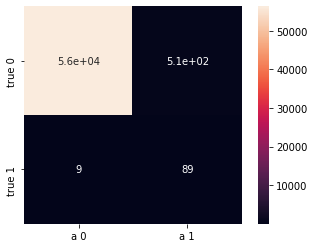

,true 0,true 1
a 0,56350,9
a 1,514,89


In [ ]:
y_pred_prob = model.predict_proba(X_test_all_c)
y_pred = model.predict(X_test_all_c)

built_conf_matr(y_test_all_c, y_pred)

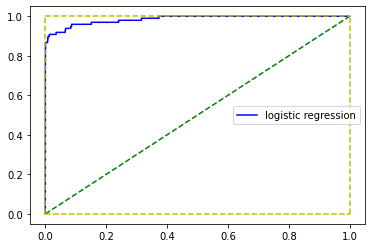

roc_auc after normalization: 0.984970854197053


In [ ]:
fpr_, tpr_ = built_roc_auc(y_test_all_c, y_pred_proba);
print('roc_auc after normalization:',  auc(fpr_, tpr_))
